Imports & Environment Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import shap
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.ensemble import GradientBoostingRegressor
from scipy.stats import ks_2samp, wasserstein_distance

Data Loading

In [4]:
df = pd.read_csv("automobile_resale_dataset.csv")
df.head()

,vehicle_id,manufacturer,vehicle_type,engine_cc,horsepower,fuel_type,transmission,mileage_kmpl,vehicle_age_years,annual_maintenance_cost,resale_price
0,1,Tesla,Hatchback,3449,179,Hybrid,Automatic,21.96,4,4542.77,53131.58
1,2,BMW,SUV,2446,305,Diesel,Manual,32.77,5,835.54,59077.80
2,3,Mercedes,Sedan,2703,115,Diesel,Automatic,11.10,3,1782.59,42301.64
3,4,Tesla,SUV,2182,97,Hybrid,Automatic,9.92,5,726.66,35366.06
4,5,Ford,Electric,944,304,Petrol,Automatic,31.00,1,2214.70,56922.14


Exploratory Data Analysis (EDA)

In [20]:
df.shape

(5000, 14)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype   
---  ------                   --------------  -----   
 0   vehicle_id               5000 non-null   int64   
 1   manufacturer             5000 non-null   object  
 2   vehicle_type             5000 non-null   object  
 3   engine_cc                5000 non-null   int64   
 4   horsepower               5000 non-null   int64   
 5   fuel_type                5000 non-null   object  
 6   transmission             5000 non-null   object  
 7   mileage_kmpl             5000 non-null   float64 
 8   vehicle_age_years        5000 non-null   int64   
 9   annual_maintenance_cost  5000 non-null   float64 
 10  resale_price             5000 non-null   float64 
 11  power_to_cc              5000 non-null   float64 
 12  maintenance_per_year     5000 non-null   float64 
 13  mileage_bucket           5000 non-null   category
dtypes: categ

In [24]:
df.duplicated().sum()

np.int64(0)

Distribution of Resale Prices

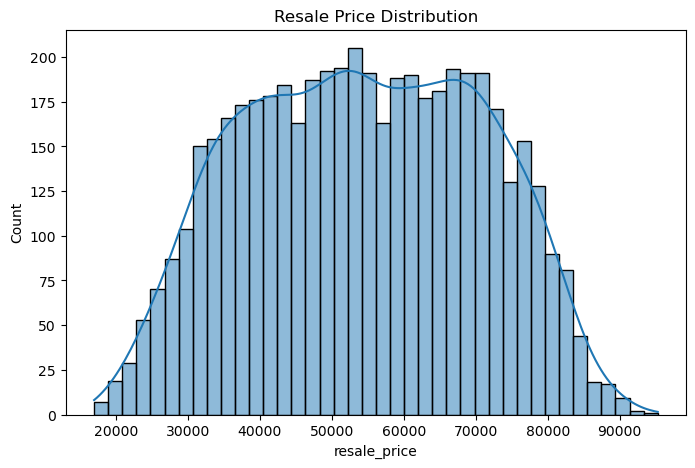

In [5]:
plt.figure(figsize=(8,5))
sns.histplot(df["resale_price"], bins=40, kde=True)
plt.title("Resale Price Distribution")
plt.show()

Vehicle Age vs Resale Price

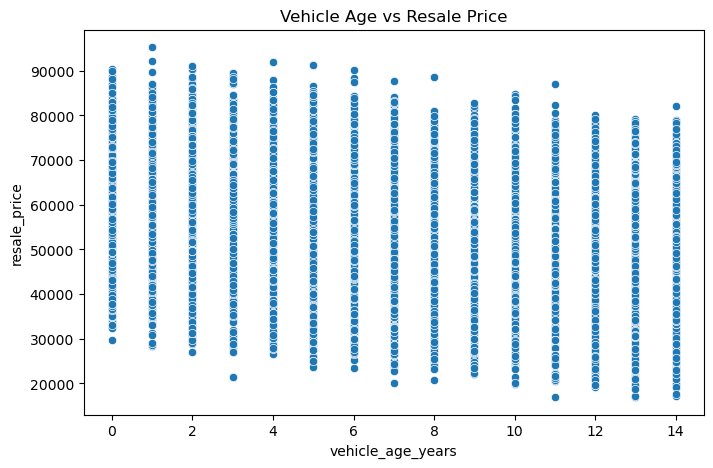

In [6]:
plt.figure(figsize=(8,5))
sns.scatterplot(x="vehicle_age_years", y="resale_price", data=df)
plt.title("Vehicle Age vs Resale Price")
plt.show()

Manufacturer-wise Resale Price

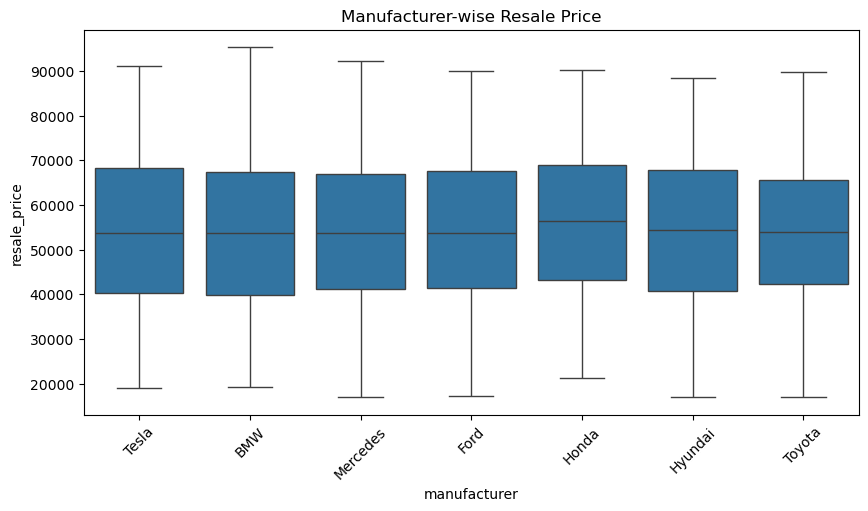

In [7]:
plt.figure(figsize=(10,5))
sns.boxplot(x="manufacturer", y="resale_price", data=df)
plt.xticks(rotation=45)
plt.title("Manufacturer-wise Resale Price")
plt.show()

Correlation Heatmap

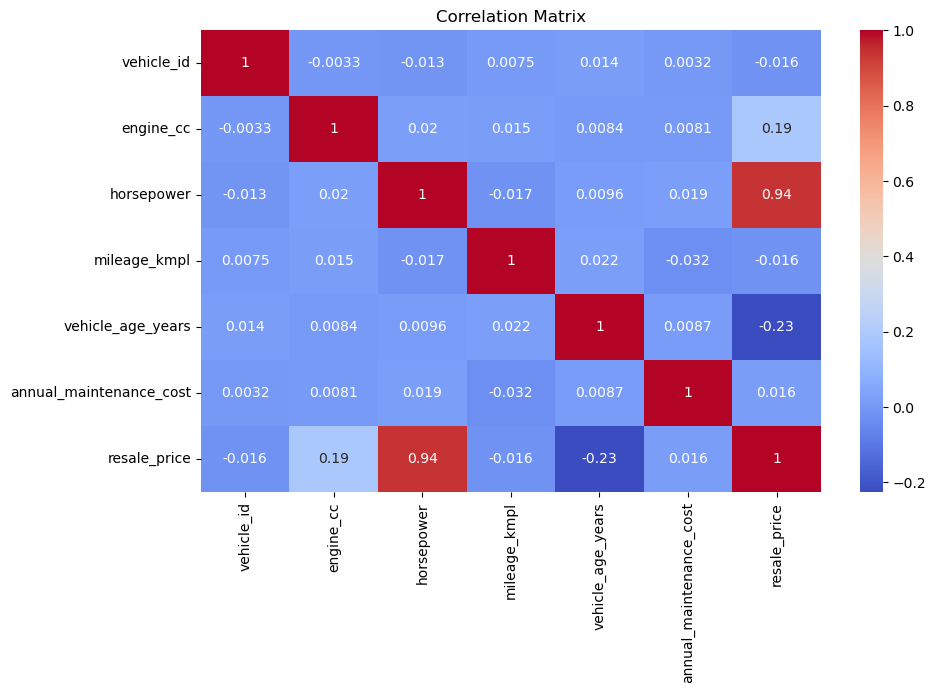

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.select_dtypes("number").corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

Feature Engineering

In [9]:
def engineer_features(df):
    df = df.copy()

    df["power_to_cc"] = df["horsepower"] / df["engine_cc"]
    df["maintenance_per_year"] = df["annual_maintenance_cost"] / (df["vehicle_age_years"] + 1)

    df["mileage_bucket"] = pd.cut(
        df["mileage_kmpl"],
        bins=[0, 12, 18, 25, 40],
        labels=["Low", "Medium", "High", "Very High"]
    )
    return df

df = engineer_features(df)
df.head()

,vehicle_id,manufacturer,vehicle_type,engine_cc,horsepower,fuel_type,transmission,mileage_kmpl,vehicle_age_years,annual_maintenance_cost,resale_price,power_to_cc,maintenance_per_year,mileage_bucket
0,1,Tesla,Hatchback,3449,179,Hybrid,Automatic,21.96,4,4542.77,53131.58,0.051899,908.554000,High
1,2,BMW,SUV,2446,305,Diesel,Manual,32.77,5,835.54,59077.80,0.124693,139.256667,Very High
2,3,Mercedes,Sedan,2703,115,Diesel,Automatic,11.10,3,1782.59,42301.64,0.042545,445.647500,Low
3,4,Tesla,SUV,2182,97,Hybrid,Automatic,9.92,5,726.66,35366.06,0.044455,121.110000,Low
4,5,Ford,Electric,944,304,Petrol,Automatic,31.00,1,2214.70,56922.14,0.322034,1107.350000,Very High


Feature-Target Separation

In [10]:
X = df.drop(columns=["resale_price", "vehicle_id"])
y = df["resale_price"]

categorical_features = [
    "manufacturer", "vehicle_type", "fuel_type",
    "transmission", "mileage_bucket"
]

numerical_features = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer([
    ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ("num", "passthrough", numerical_features)
])

Preprocessing Pipeline

In [11]:
model = GradientBoostingRegressor(
    n_estimators=400,
    learning_rate=0.04,
    max_depth=5,
    subsample=0.8,
    random_state=42
)

pipeline = Pipeline([
    ("prep", preprocessor),
    ("model", model)
])

pipeline.fit(X, y)
joblib.dump(pipeline, "resale_model.pkl")
print("Model trained & saved.")

Model trained & saved.


Model Training & Model Evaluation

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

preds = pipeline.predict(X_test)

print("MAE:", mean_absolute_error(y_test, preds))
print("R2 :", r2_score(y_test, preds))

MAE: 1669.0644832706853
R2 : 0.9833285270795598


Model Explainability (SHAP)

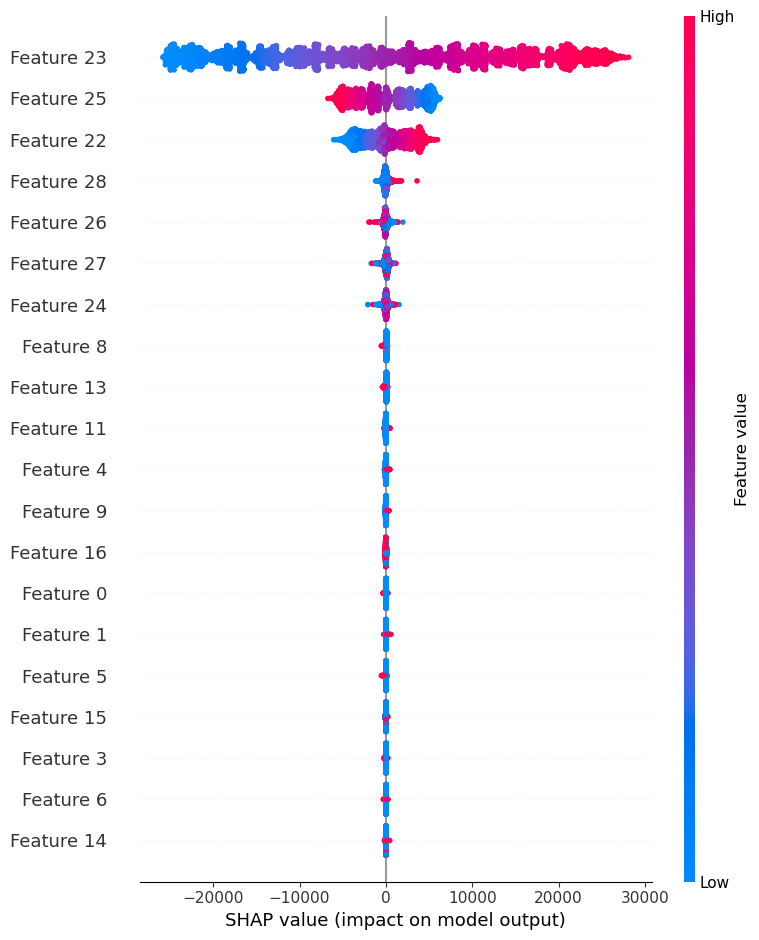

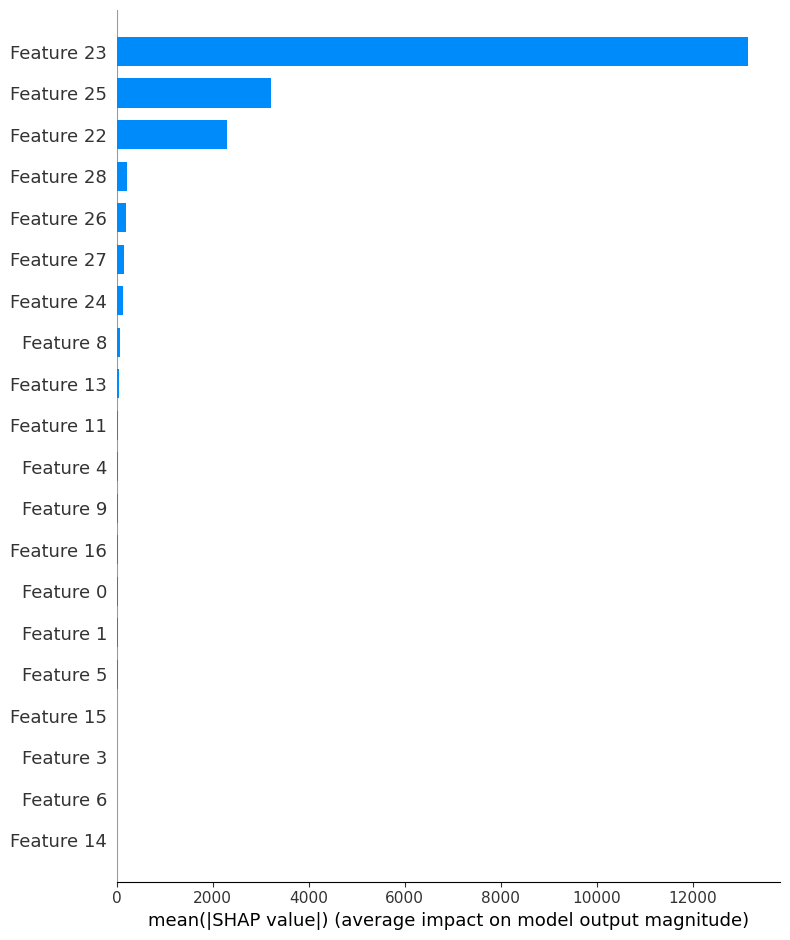

In [13]:
prep = pipeline.named_steps["prep"]
gb_model = pipeline.named_steps["model"]

X_transformed = prep.transform(X)

explainer = shap.Explainer(gb_model)
shap_values = explainer(X_transformed)

shap.summary_plot(shap_values, X_transformed)
shap.summary_plot(shap_values, X_transformed, plot_type="bar")

Baseline Statistics for Drift Detection

In [14]:
baseline_stats = {}

for col in df.select_dtypes("number").columns:
    baseline_stats[col] = {
        "mean": df[col].mean(),
        "std": df[col].std()
    }

baseline_df = pd.DataFrame(baseline_stats).T
baseline_df

,mean,std
vehicle_id,2500.500000,1443.520003
engine_cc,2387.458000,921.823798
horsepower,279.624200,126.925987
mileage_kmpl,21.468828,7.815428
vehicle_age_years,7.127600,4.273520
annual_maintenance_cost,2613.425256,1344.140699
resale_price,54316.421310,16241.521217
power_to_cc,0.140129,0.095697
maintenance_per_year,549.971196,703.556742


In [15]:
def detect_data_drift(reference_df, live_df, alpha=0.05):
    drift_results = []

    for col in reference_df.index:
        if col in live_df.columns:
            stat, p = ks_2samp(
                live_df[col].dropna(),
                np.random.normal(
                    reference_df.loc[col, "mean"],
                    reference_df.loc[col, "std"],
                    size=len(live_df)
                )
            )
            drift_results.append({
                "feature": col,
                "p_value": p,
                "drift_detected": p < alpha
            })

    return pd.DataFrame(drift_results)

live_sample = df.sample(400)
data_drift_report = detect_data_drift(baseline_df, live_sample)
data_drift_report

,feature,p_value,drift_detected
0,vehicle_id,2.107056e-01,False
1,engine_cc,2.424717e-02,True
2,horsepower,4.157888e-01,False
3,mileage_kmpl,4.368337e-04,True
4,vehicle_age_years,7.945213e-03,True
5,annual_maintenance_cost,6.405072e-01,False
6,resale_price,3.221851e-01,False
7,power_to_cc,3.596290e-05,True
8,maintenance_per_year,4.640300e-12,True


In [16]:
reference_preds = pipeline.predict(X)
live_preds = pipeline.predict(live_sample.drop(columns=["resale_price", "vehicle_id"]))

drift_score = wasserstein_distance(reference_preds, live_preds)

print("Prediction Drift Score:", drift_score)
print("Drift Detected:", drift_score > 3000)

Prediction Drift Score: 725.6125131723397
Drift Detected: False


In [17]:
def monitor_performance(y_true, y_pred):
    return {
        "MAE": mean_absolute_error(y_true, y_pred),
        "R2": r2_score(y_true, y_pred)
    }

simulated_preds = y_test * 0.9  
performance_metrics = monitor_performance(y_test, simulated_preds)
performance_metrics

{'MAE': 5457.894403999999, 'R2': 0.8753053351843906}

In [19]:
if performance_metrics["MAE"] > 3500:
    print("Model performance degraded. Retraining recommended.")

Model performance degraded. Retraining recommended.
